In [31]:
library("dplyr")
library("Seurat")
library("patchwork")
library("ggplot2")
library("clustree")

In [32]:
day4.data = Read10X(data.dir = "../Day4/filtered_feature_bc_matrix/")

day4_Seurat1 = CreateSeuratObject(counts = day4.data, project = "Day4", min.cells = 3, min.features = 2000)
print(day4_Seurat1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
19023 features across 2313 samples within 1 assay 
Active assay: RNA (19023 features, 0 variable features)
 1 layer present: counts


In [33]:
head(day4_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCACAACCAACT-1,Day4,4674,2191
AAACCCACAACCGCCA-1,Day4,5309,2353
AAACCCATCGTTGCCT-1,Day4,10086,3255
AAACGCTCAATCCAGT-1,Day4,4721,2227
AAACGCTGTCTACAAC-1,Day4,10088,2714
AAAGAACAGACTGGGT-1,Day4,8558,3419
AAAGAACTCCGACAGC-1,Day4,6974,3072
AAAGGATTCGCTTTAT-1,Day4,10576,2963
AAAGGGCAGATTGGGC-1,Day4,4929,2068


### Add the percent of mitochondrial genes

In [34]:
# NOTE: only works when using LOWERCASE mt
day4_Seurat1[["percent.mt"]] = PercentageFeatureSet(day4_Seurat1, pattern = "^mt-")
head(day4_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCACAACCAACT-1,Day4,4674,2191,5.070603
AAACCCACAACCGCCA-1,Day4,5309,2353,3.258617
AAACCCATCGTTGCCT-1,Day4,10086,3255,2.667063
AAACGCTCAATCCAGT-1,Day4,4721,2227,3.812752
AAACGCTGTCTACAAC-1,Day4,10088,2714,1.605868
AAAGAACAGACTGGGT-1,Day4,8558,3419,1.402197
AAAGAACTCCGACAGC-1,Day4,6974,3072,5.735589
AAAGGATTCGCTTTAT-1,Day4,10576,2963,3.593041
AAAGGGCAGATTGGGC-1,Day4,4929,2068,1.765064


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


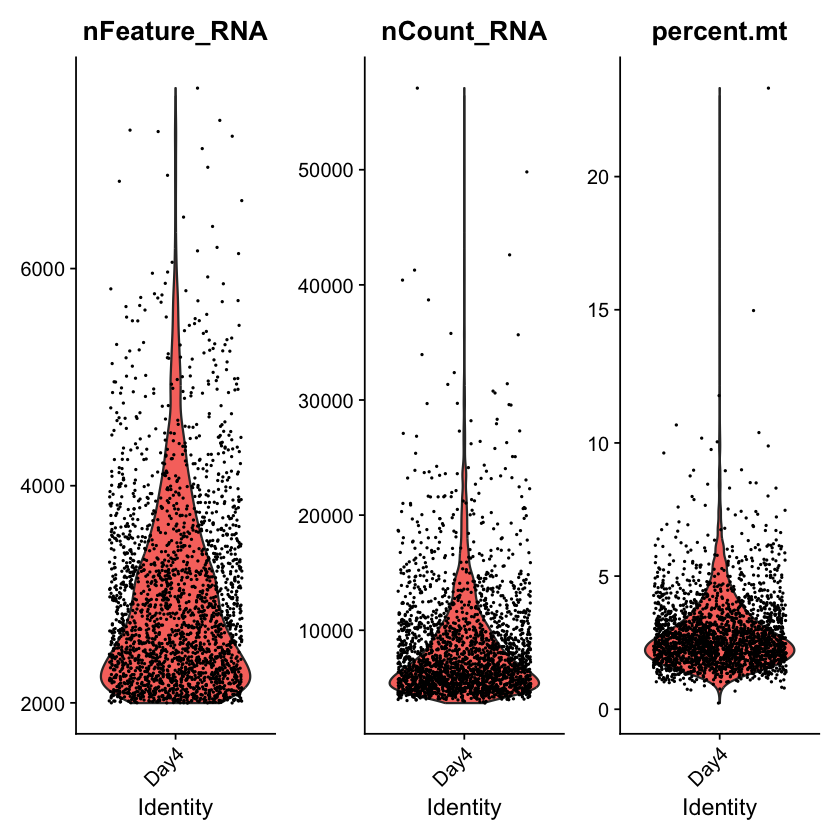

In [35]:
# Visualize QC metrics as a violin plot
# Start here to see the general trend of RNA and Counts
Vln_plots1 = VlnPlot(day4_Seurat1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(Vln_plots1)

In [8]:
pdf(file = "../Day4/figures/Day4_violin_plots.pdf",
    width = 10,
    height = 10)
print(Vln_plots1)
dev.off()

agg_record_229127449 
                   2

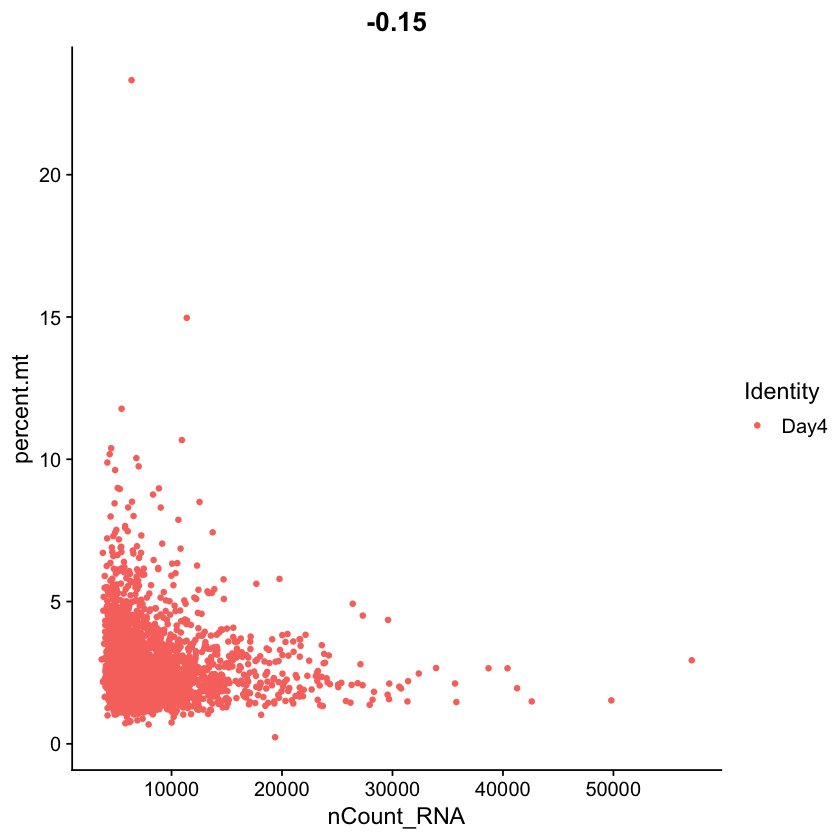

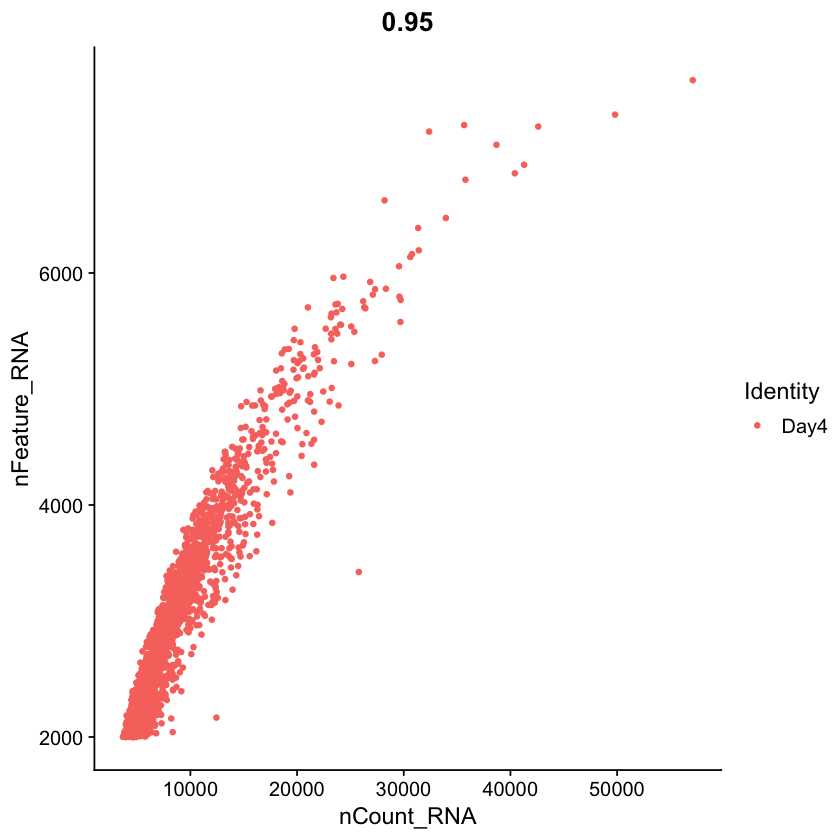

In [36]:
# FeatureScatter is typically used to visualize feature-feature 
# relationships, but can be used for anything calculated by the 
# object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(day4_Seurat1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(day4_Seurat1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
print(plot1)
print(plot2)

In [37]:
# Gather cells samples that have more than 200 genes and less than 5,000. 
# Anything less is most likely empty, anything higher than 5,000 most 
# likely contains more than one cell.
# Remove any cells that have more than 10 percent mitochondrial 
# counts as these are likely artifacts. Cell membrane is compromised 
# or mRNA leakage where only the mitochondrial mRNA remains
day4_Seurat2 <- subset(day4_Seurat1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)

### Normalize the data

In [38]:
day4_Seurat3 = NormalizeData(object = day4_Seurat2, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



### Identification of highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


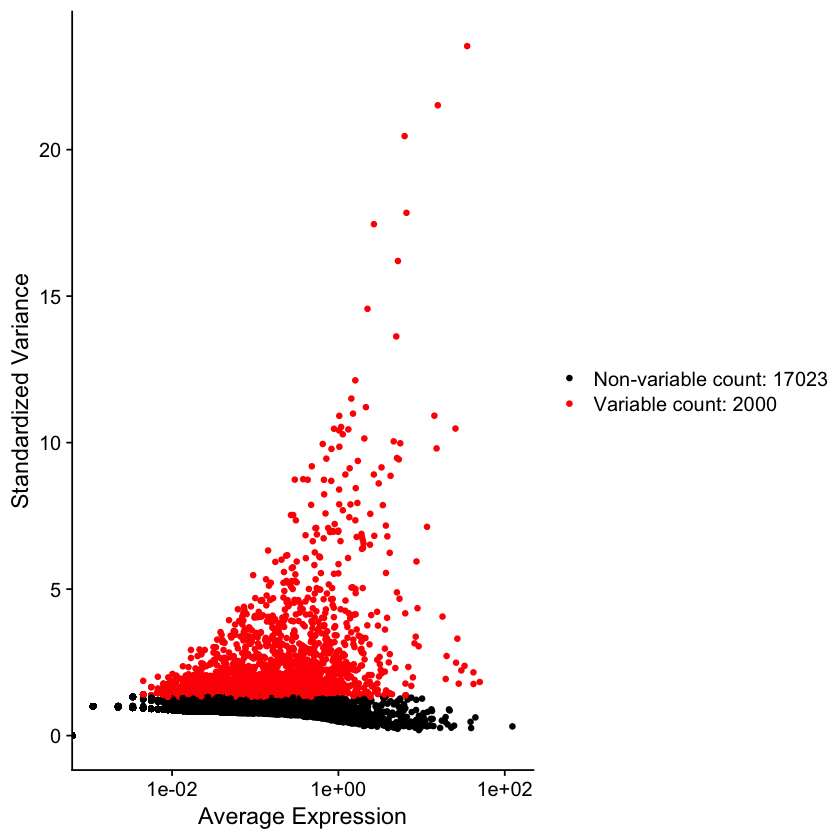

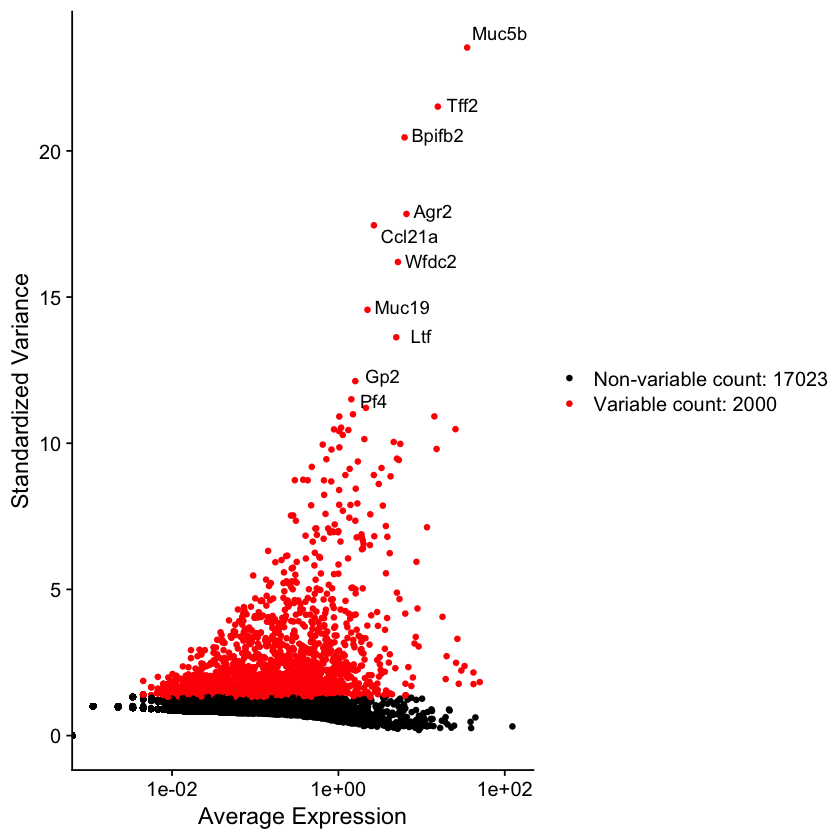

In [39]:
day4_Seurat3 = FindVariableFeatures(day4_Seurat3, selection.method = "vst", nfeatures = 2000)

#plot the top 10 features
top10 = head(VariableFeatures(day4_Seurat3),10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(day4_Seurat3)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

In [28]:
pdf(file = "../Day4/figures/Day4_top_10_VE_genes.pdf",
    width = 10,
    height = 10)
print(plot2)
dev.off()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


agg_record_159496774 
                   2

In [27]:
#save the top 10 VE genes with their p values
hvf_info = HVFInfo(day4_Seurat3)
top10_genes = head(VariableFeatures(day4_Seurat3), 10)

top10_df = hvf_info[top10_genes, ] %>%
                                  tibble::rownames_to_column(var = "gene")
print(top10_df)
write.csv(top10_df, file = "../Day4/results/top_10_VE_genes_day_4.csv", row.names = FALSE)

     gene      mean    variance variance.expected variance.standardized
1   Muc5b 35.322835 28113.53868       1074.735452              23.53484
2    Tff2 15.673791  5662.83941        227.011536              21.51557
3  Bpifb2  6.246344   979.37280         43.166437              20.46230
4    Agr2  6.579303   933.47146         47.281533              17.84403
5  Ccl21a  2.671541   266.20731         10.147483              17.45617
6   Wfdc2  5.197975   520.08238         31.353856              16.19980
7   Muc19  2.237345   151.08212          7.570096              14.56607
8     Ltf  4.959505  1475.62674         28.910567              13.62495
9     Gp2  1.596175    55.05859          4.369395              12.12549
10    Pf4  1.430821    42.49099          3.665210              11.50392


### Scaling the data

In [40]:
all.genes = rownames(day4_Seurat3)
day4_Seurat4 = ScaleData(day4_Seurat3, features = all.genes)

Centering and scaling data matrix



In [53]:
# Remove unwanted sources of variation from a single-cell dataset such as mitochondrial contamination.
day4_Seurat4 <- ScaleData(day4_Seurat4, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



### Perform linear dimensional reduction

In [54]:
day4_Seurat5 = RunPCA(day4_Seurat4, features = VariableFeatures(object = day4_Seurat4))

PC_ 1 
Positive:  Fcer1g, Ctss, Laptm5, Tyrobp, Ms4a6c, Lcp1, Spi1, Cd53, Lyz2, Csf1r 
	   Cd68, Ucp2, Cd52, Ptprc, Cd300c2, Alox5ap, Mpeg1, C1qb, Pld4, Fcgr3 
	   Ccl9, Cybb, Cd14, Ms4a6d, Ifi30, Coro1a, C1qa, C1qc, Wfdc17, Aif1 
Negative:  Sparc, Mmp2, Col1a2, Serping1, Col3a1, Col1a1, Igfbp4, Col5a2, Dcn, Col6a1 
	   Plpp3, Lum, Col6a2, Col6a3, Fbln1, Nbl1, C1s1, Gsn, Aebp1, Gas1 
	   Htra1, Fbn1, Ccdc80, Postn, Igfbp6, Prelp, Apod, Meg3, Cdh11, Rarres2 
PC_ 2 
Positive:  Col1a2, Col1a1, Gsn, Col3a1, Lum, Ftl1, Col6a1, Dcn, Col6a3, Fbln1 
	   Mmp2, Col6a2, Fn1, Lgals3, Cyba, Ctsk, Htra1, Fth1.1, Psap, Igf1 
	   Ctsb, Gas1, Postn, Olfml3, Cdh11, C1s1, Meg3, Ctsz, Apod, Igfbp4 
Negative:  Pecam1, Mmrn2, Cdh5, Ecscr, Emcn, Cyyr1, Esam, Egfl7, Ptprb, Rasip1 
	   Lrg1, Ctla2a, Apold1, Flt1, Plvap, Gimap6, Podxl, Tm4sf1, Tek, Kdr 
	   Tie1, Pdlim1, Adgrf5, Epas1, Myct1, Rnd1, Grrp1, Eng, Tspan7, Selp 
PC_ 3 
Positive:  Tmsb4x, Fxyd5, Cd93, Pecam1, Cdh5, Plxnd1, Eng, Flt1, Esam, Ptprb 
	  

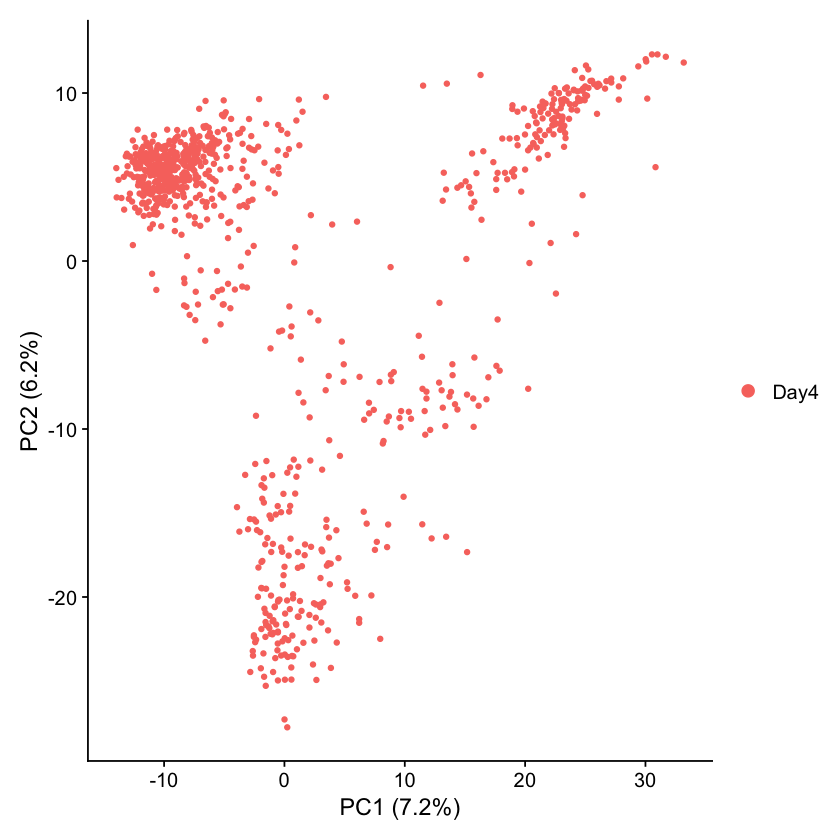

In [55]:
# To add the percent of variation explained by each component
pca_var <- Seurat::Stdev(object = day4_Seurat5, reduction = "pca")
pca_var_perc <- pca_var / sum(pca_var) * 100

pc1_perc <- round(pca_var_perc[1], 1)
pc2_perc <- round(pca_var_perc[2], 1)

PCA_plot1 = DimPlot(day4_Seurat5, reduction = "pca") +
                  xlab(paste0("PC1 (", round(pca_var_perc[1],1), "%)")) +
                  ylab(paste0("PC2 (", round(pca_var_perc[2],1), "%)"))
print(PCA_plot1)

In [56]:
pdf(file = "../Day4/figures/Day4_PCA.pdf",
    width = 10,
    height = 10)
print(PCA_plot1)
dev.off()

agg_record_96143414 
                  2

### Determine the dimensionality of the dataset

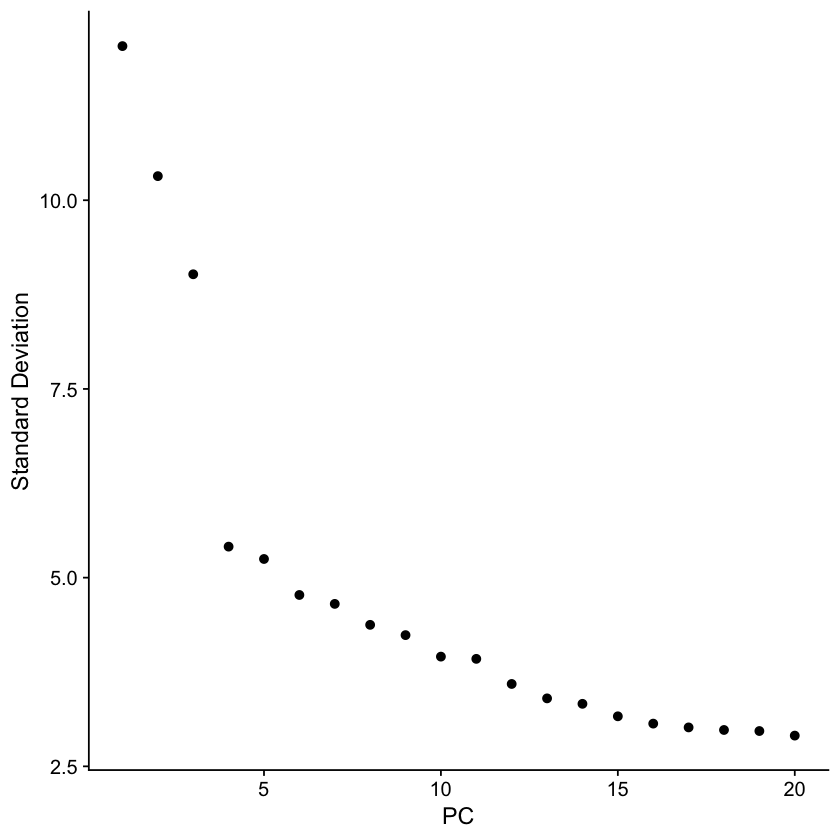

In [43]:
ElbowPlot(day4_Seurat5)

### Cluster the cells

In [44]:
# resolution
# Value of the resolution parameter, use a value above (below) 
# 1.0 if you want to obtain a larger (smaller) number of communities.
day4_Seurat5 = FindNeighbors(day4_Seurat5, dims = 1:50)
day4_Seurat5 = FindClusters(day4_Seurat5, resolution = c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 889
Number of edges: 29176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9350
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 889
Number of edges: 29176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8904
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 889
Number of edges: 29176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8459
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 889
Number of edges: 29176

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8134
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer version

In [45]:
head(Idents(day4_Seurat5), 5)

AAACCCACAACCAACT-1 AAACCCACAACCGCCA-1 AAACGCTCAATCCAGT-1 AAAGGGCAGATTGGGC-1 
                 2                  1                  4                  9 
AAAGTGAAGCTGAGTG-1 
                 3 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

### Run non-linear dimensional reduction, UMAP

In [46]:
day4_Seurat5 = RunUMAP(day4_Seurat5, dims = 1:50)

10:56:30 UMAP embedding parameters a = 0.9922 b = 1.112

10:56:30 Read 889 rows and found 50 numeric columns

10:56:30 Using Annoy for neighbor search, n_neighbors = 30

10:56:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:56:30 Writing NN index file to temp file /var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//RtmpmKfuST/file82033475c5a

10:56:30 Searching Annoy index using 1 thread, search_k = 3000

10:56:30 Annoy recall = 100%

10:56:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:56:30 Initializing from normalized Laplacian + noise (using RSpectra)

10:56:30 Commencing optimization for 500 epochs, with 34336 positive edges

10:56:30 Using rng type: pcg

10:56:31 Optimization finished



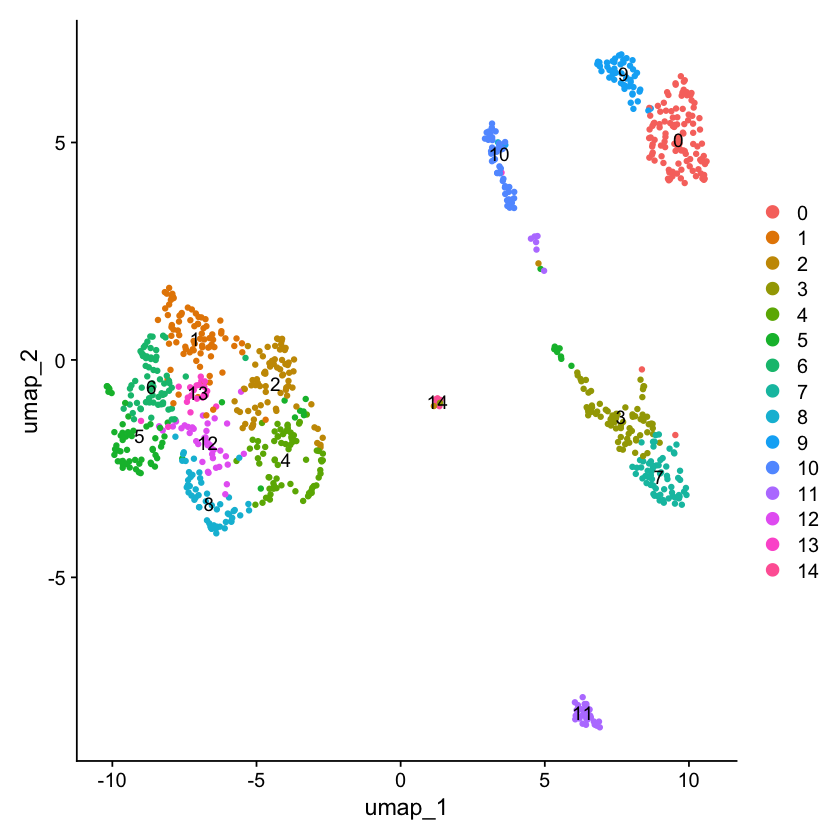

In [47]:
UMAP_plot1 = DimPlot(day4_Seurat5, reduction = "umap", label = TRUE)
print(UMAP_plot1)

In [48]:
pdf(file = "../Day4/figures/Day4_UMAP_plot.pdf",
    width = 10,
    height = 10)
print(UMAP_plot1)
dev.off()

agg_record_1652647 
                 2

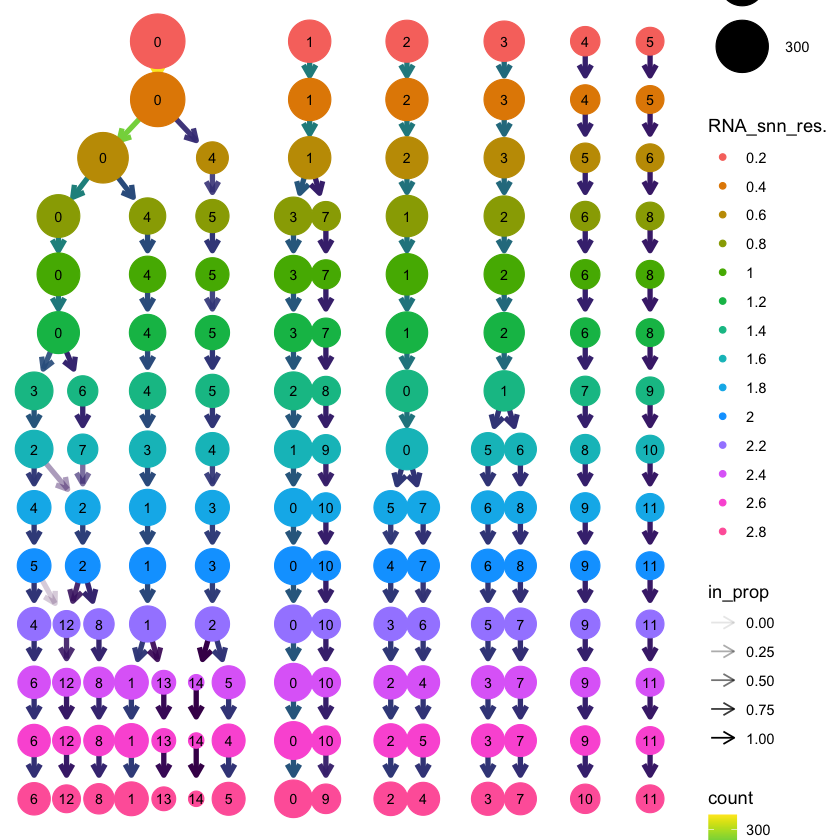

In [49]:
phylo_tree1 = clustree(day4_Seurat5, prefix = "RNA_snn_res.")
print(phylo_tree1)

In FindClusters(), resolution controls how finely the shared-nearest-neighbor (SNN) graph is cut:<br>
lower resolution → fewer, larger clusters<br>
higher resolution → more, smaller clusters<br>
Each column in clustree is a resolution. Each node is a cluster at that resolution.

In [50]:
pdf(file = "../Day4/figures/Day4_phylogenetic_tree.pdf",
    width = 10,
    height = 10)
print(phylo_tree1)
dev.off()

agg_record_1656364334 
                    2

In [51]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Tahoe 26.0.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] future_1.68.0      clustree_0.5.1     ggraph_2.2.2       ggplot2_4.0.1     
[5] patchwork_1.3.2    Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
[9] dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.4        
  [4] spatstat.utils_3.2-0   farver_2.1.2           ragg_1.5.0            
  [7] vctrs_0.6.5            ROCR_1.0-11    